In [22]:
# Useful imports
import matplotlib.pylab as plt
import numpy as np
import os
import sys
import pandas as pd

Trying to develop machinery to extract cable transmission line parameters from a simple TDR measurement using an oscilloscope.  Here's a picture of the measurement setup:

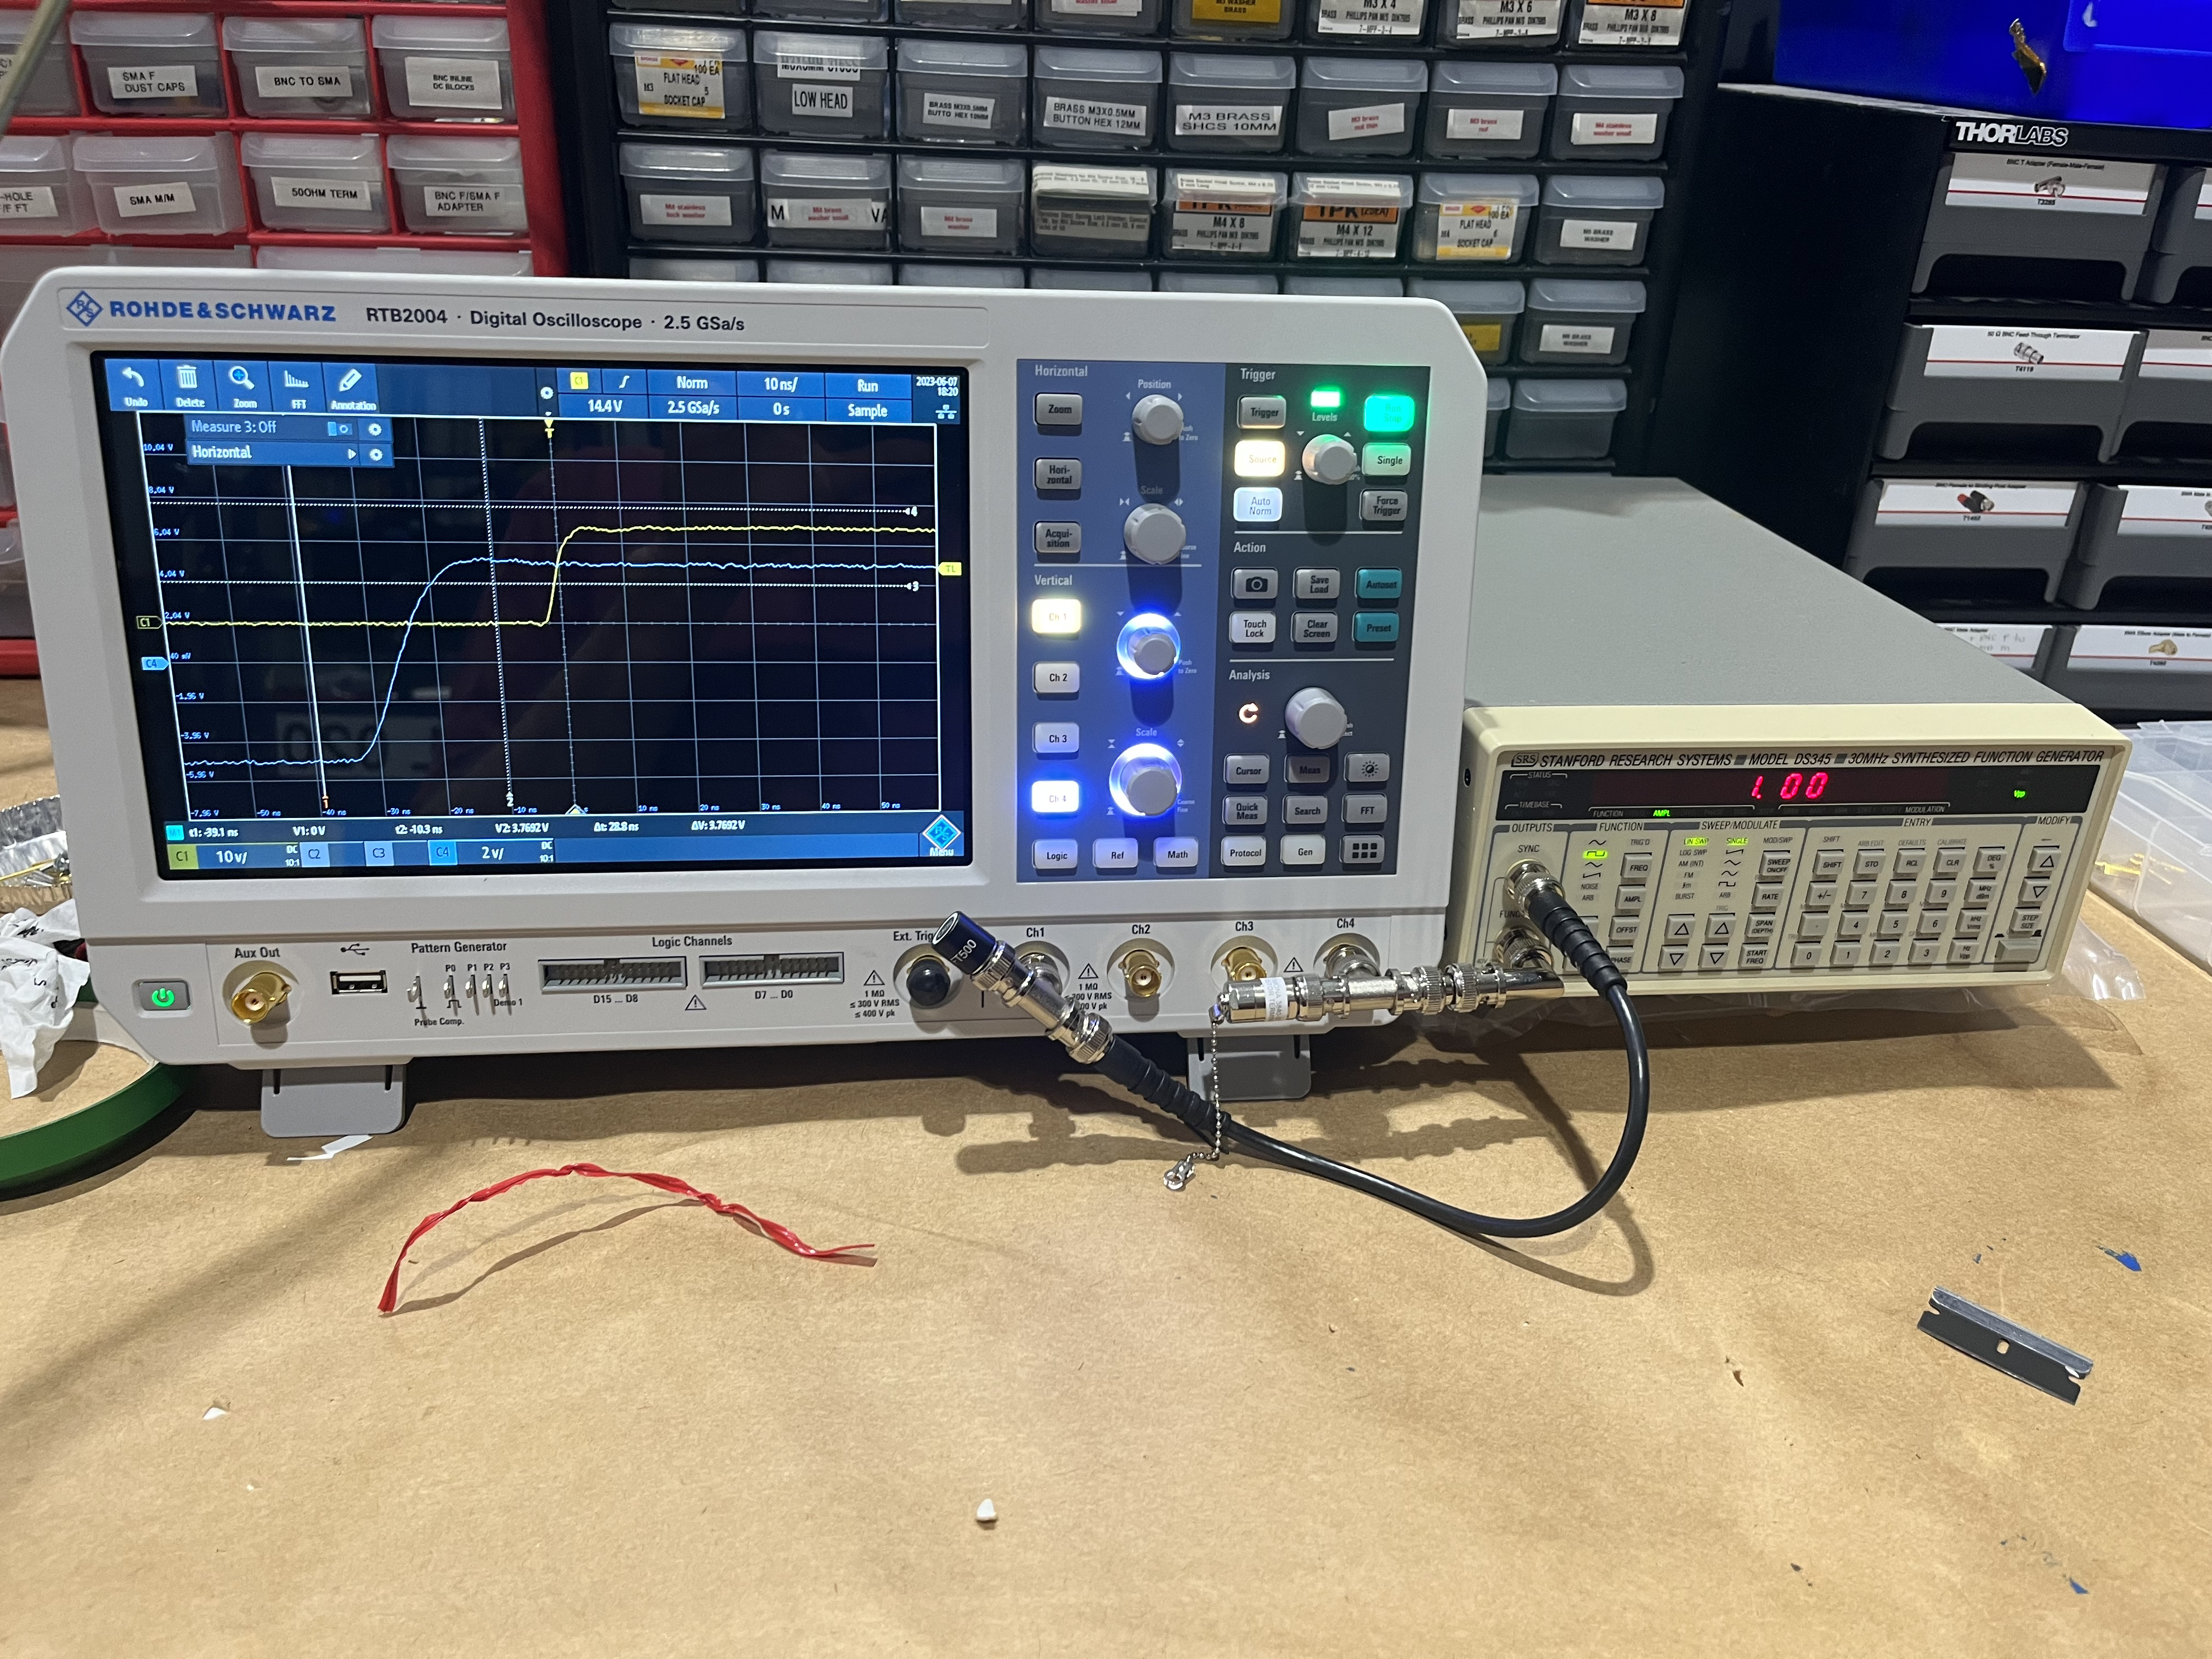

Here, measuring on channel 4 the output of the function generator.  The coax there is 12" long.  Before trying to characterize a CMB cable, let's try something easy, a 125" long RG58c/u cable.  From typical [spec sheet](rg58c-u.pdf) (not for this specific cable which is a Qualtronix mil type RG 58C/U cable), expect capacitance will be somewhere around 30.8 pF/ft and inductance will be

In [12]:
50**2*(30.8e-12)

7.7e-08

77 nH.  Took the following datasets:

| Data file | Termination |
| --- | --- |
| [20230607_longrg58cu_GLSD01.csv](data/first_long_coax_attempt_20230607/20230607_longrg58cu_GLSD01.csv) | 50 Ohm termination as in above picture |
| [20230607_longrg58cu_GLSD02.csv](data/first_long_coax_attempt_20230607/20230607_longrg58cu_GLSD02.csv) | 125" long RG58C/U cable, open at end furthest from oscilloscope |
| [20230607_longrg58cu_GLSD03.csv](data/first_long_coax_attempt_20230607/20230607_longrg58cu_GLSD03.csv) | 125" long RG58C/U cable, end furthest from oscilloscope shorted |
| [20230607_longrg58cu_GLSD04.csv](data/first_long_coax_attempt_20230607/20230607_longrg58cu_GLSD04.csv) | 125" long RG58C/U cable, end furthest from oscilloscope terminated into 49.8 Ohm |
| [20230607_longrg58cu_GLSD05.csv](data/first_long_coax_attempt_20230607/20230607_longrg58cu_GLSD05.csv) | 125" long RG58C/U cable, end furthest from oscilloscope terminated into 25 Ohm |
| [20230607_longrg58cu_GLSD06.csv](data/first_long_coax_attempt_20230607/20230607_longrg58cu_GLSD06.csv) | 125" long RG58C/U cable, end furthest from oscilloscope terminated into 75 Ohm |


We'll use the SPICE PWL source to generate the measured function generator pulse.  First generate a PWL file from the dataset with the 50 Ohm termination instead of the cable.

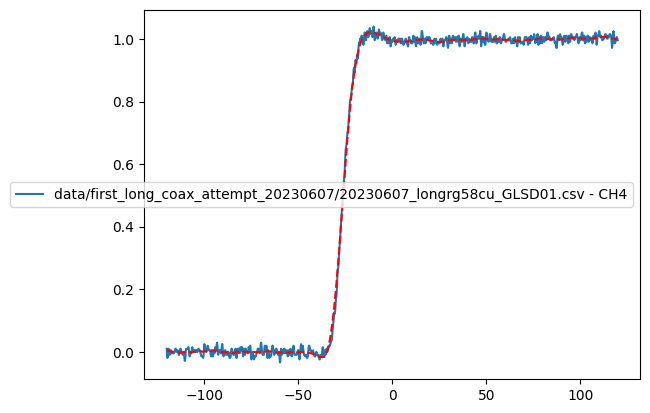

In [14]:
sys.argv[1]='data/first_long_coax_attempt_20230607/20230607_longrg58cu_GLSD01.csv'; exec(open('make_pwl_file.py').read())

A filtered version of the measured pulse is saved to the PWL file.  The first column is the time in ns, starting from zero (ignoring offset in data), and the second is in mV.  The columns are comma delimited.  For simplicity, shift vertical level of data so that it starts at zero.

In [20]:
!head -n 5 pwlfiles/20230607_longrg58cu_GLSD01.pwl


0.000n,4.583m
0.200n,4.380m
0.400n,4.399m
0.600n,4.538m
0.800n,4.553m


Copy [ltra_test.asc](ltra_test.asc) to tdr_10ftrg58cu.asc and edit to look like this:

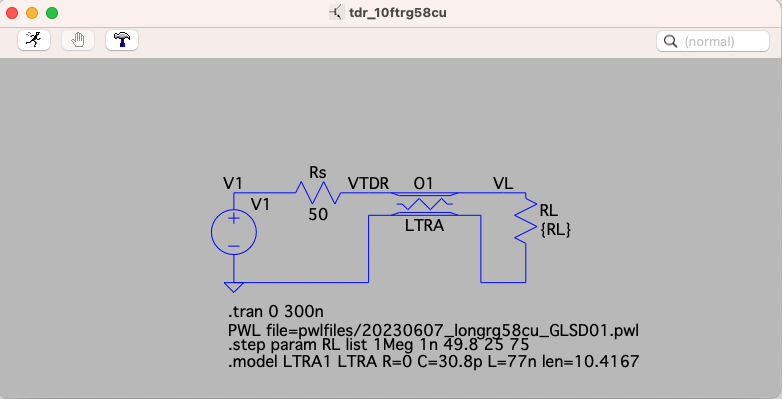

This will simulate the circuit shown for the listed RLs.

Next, run the simulation and leave the plot open.  We can then use the ltspice python library to plot our TDR measurements versus the simulation like this (can install this module with `pip3 install ltspice`):

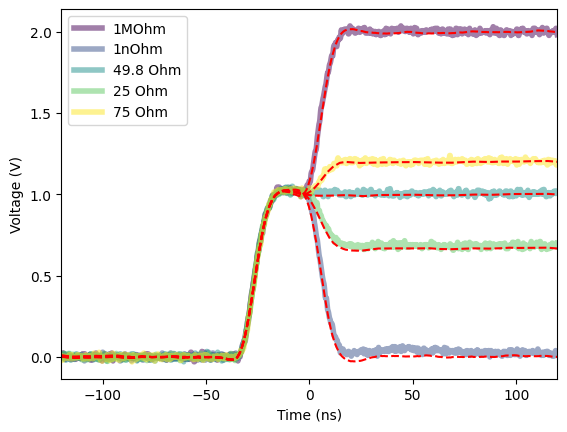

In [62]:
import ltspice

#
# Data
#
datafiles=[f'data/first_long_coax_attempt_20230607/20230607_longrg58cu_GLSD0{ii}.CSV' for ii in [2,3,4,5,6]]
# LTSpice trans data starts at zero, so pull the start time from the first dataset and use to offset the model data.
# assumes datasets were all taken with the same time offset.
datalabels=['1MOhm',"1nOhm","49.8 Ohm","25 Ohm","75 Ohm"]
mint,maxt=None,None

# Pick a nice color map
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(0,1,len(datafiles))))

# Load datasets, and plot.  Also extract time offset for model.
for datalabel,datafile in zip(datalabels,datafiles):
    datadf=pd.read_csv(datafile, index_col=False)
    datadf=datadf.dropna(axis=1,how='all')
    
    t_ns=1.e9*datadf['in s'].values
    v4=datadf['C4 in V'].values
    v4=v4-np.mean(v4[:200]) # shifts starting voltage to zero to simplify plots
    plt.plot(t_ns,v4,label=f'{datalabel}',alpha=0.5,lw=4) # plot with some transparency so can overlay model
    if mint is None:
        mint=np.min(t_ns)
        maxt=np.max(t_ns)

#
# Overplot model.  LTSpice must be open and sim must have been run.
#
ascpath = 'tdr_10ftrg58cu.raw'
l = ltspice.Ltspice(ascpath)
l.parse() # Data loading sequence. It may take few minutes for huge file.

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(0,1,len(datafiles))))

for i in range(l.case_count):
    time = l.get_time(i)    
    vtdr = l.get_data('V(vtdr)',i)
    plt.plot(mint+time*1.e9,2.*vtdr,'r--') # 2x here because fcn gen outputs 2x the programmed signal in 50 Ohm mode

plt.xlabel('Time (ns)')
plt.xlim(mint,maxt)
plt.ylabel('Voltage (V)')

plt.legend()

It actually...agrees!